In [1]:
#import proglearn
#from proglearn.forest import UncertaintyForest
import hyppo
import numpy as np
from numba import njit
from hyppo.independence.base import IndependenceTest
from hyppo._utils import perm_test
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import copy 
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree._classes import DecisionTreeClassifier
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal
from scipy.integrate import nquad

In [2]:
import sys
sys.executable
sys.path
sys.path.append('C:\\Users\\siptest\\AppData\\Roaming\\Python\\Python36\\Scripts')

In [3]:
def uf(X, y, n_estimators = 300, max_samples = .4, base = np.exp(1), kappa = 3):
    
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(), 
                              n_estimators=n_estimators, 
                              max_samples=max_samples, 
                              bootstrap=False)
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    _, y = np.unique(y, return_inverse=True)
    
    cond_entropy = 0
    for tree_idx, tree in enumerate(model):
        # Find the indices of the training set used for partition.
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0,n), sampled_indices)
        
        # Randomly split the rest into voting and evaluation.
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        vote_indices = unsampled_indices[:total_unsampled//2]
        eval_indices = unsampled_indices[total_unsampled//2:]
        
        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        est_nodes = tree.apply(X[vote_indices])
        est_classes = y[vote_indices]
        for i in range(len(est_nodes)):
            class_counts[est_nodes[i], est_classes[i]] += 1
        
        row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
        row_sums[row_sums == 0] = 1 # Avoid divide by zero.
        class_probs = class_counts / row_sums[:, None]
        
        # Make the nodes that have no estimation indices uniform.
        # This includes non-leaf nodes, but that will not affect the estimate.
        class_probs[np.argwhere(class_probs.sum(axis = 1) == 0)] = [1 / K]*K
        
        # Apply finite sample correction and renormalize.
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
        row_sums = class_probs.sum(axis=1)
        class_probs = class_probs / row_sums[:, None]
        
        # Place evaluation points in their corresponding leaf node.
        # Store evaluation posterior in a num_eval-by-num_class matrix.
        eval_class_probs = class_probs[tree.apply(X[eval_indices])]
        # eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_entropies = [entropy(posterior) for posterior in eval_class_probs]
        cond_entropy += np.mean(eval_entropies)

      
    return cond_entropy / n_estimators
        

In [58]:
def _perm_stat(X, y, is_distsim = True, permuter = None): 
    if permuter is None: 
        order = np.random.permutation(y.shape[0])
    else: 
        order = permuter()
    
    if is_distsim: 
        permy = y[order][:, order]
    else: 
        permy = y[order]
    
    perm_stat = uf(X, permy, n, d, pis, num_trials)
    
    return perm_stat

In [61]:
def perm_test(X, y, workers = -1, is_distsim=True, perm_block = None, reps = 1000): 

    # calculate observed test statistic
    stat = uf(X, y, n, d, pis, num_trials)
    #print(stat) 

    # calculate null distribution
    null_dist = np.array(
        Parallel(n_jobs=-2)(
            [
                delayed(_perm_stat)(X, y, False) 
                for rep in range(reps)
            ]
        )
    )
            
    pvalue = (null_dist >= stat).sum() / reps

    # correct for a p-value of 0. This is because, with bootstrapping
    # permutations, a p-value of 0 is incorrect
    if pvalue == 0:
        pvalue = 1 / reps

    #return stat, pvalue, null_dist
    print(stat, pvalue, null_dist)
    return pvalue

C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6882504989003334 0.46 [0.68696312 0.68789031 0.69013637 0.68903774 0.68703539 0.68860666
 0.68809491 0.6889199  0.68723311 0.68743676 0.68949476 0.68940952
 0.68475198 0.68844674 0.68852202 0.68659853 0.68824805 0.68869815
 0.68994311 0.6885685  0.68771072 0.68916176 0.68755651 0.68743409
 0.68806753 0.68691363 0.68693139 0.68751875 0.68754286 0.68931
 0.68539846 0.68460715 0.68918779 0.68777622 0.67778841 0.68704522
 0.68821032 0.68826278 0.68865037 0.68826351 0.68674502 0.68882335
 0.68906289 0.68652423 0.68749564 0.68882757 0.68918424 0.68571611
 0.68833606 0.68894669]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6874971773197399 0.68 [0.68740564 0.68943156 0.68895812 0.6864178  0.68691996 0.68847648
 0.68769297 0.689841   0.68696519 0.68952166 0.68608925 0.68587719
 0.68746397 0.68948658 0.6883412  0.68899377 0.68638977 0.68963561
 0.6884916  0.68659302 0.68753824 0.68677453 0.68612608 0.68978123
 0.68920371 0.68871956 0.68877026 0.68827871 0.68650476 0.68773305
 0.68984631 0.68917346 0.68625387 0.6858535  0.68793218 0.68826247
 0.68797745 0.68950676 0.6899023  0.68708774 0.68753206 0.6896316
 0.68850323 0.68769852 0.6885046  0.68761508 0.68676104 0.68802269
 0.68888609 0.688582  ]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6897236625143504 0.12 [0.69030564 0.68804078 0.68765852 0.68833963 0.6894538  0.6892092
 0.68702384 0.68757192 0.68948198 0.68508755 0.68740736 0.68793057
 0.68998406 0.68856229 0.68993049 0.68879488 0.68811126 0.68239346
 0.68742115 0.68772333 0.68866827 0.68895866 0.68889363 0.68867156
 0.6871553  0.68920851 0.68830632 0.68746814 0.68925986 0.68985013
 0.68976794 0.68915419 0.68832423 0.68857707 0.68838554 0.68534882
 0.68988997 0.68898042 0.68834249 0.68816396 0.68729614 0.68750161
 0.68786269 0.68760713 0.68798883 0.68713191 0.68835402 0.68630234
 0.68859153 0.68882244]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6862092419974672 0.82 [0.68809027 0.68796817 0.68707995 0.68499951 0.68608639 0.68935278
 0.6839812  0.6882876  0.68503216 0.68731085 0.68904544 0.68723374
 0.68833106 0.68894576 0.68758451 0.68867334 0.68853684 0.68841905
 0.68775129 0.68165774 0.68879517 0.68882069 0.68798026 0.68798423
 0.68936426 0.68687257 0.68810254 0.68788785 0.68962183 0.68607757
 0.68727063 0.68704783 0.68818861 0.68932706 0.68899789 0.68865779
 0.684224   0.68616749 0.68953643 0.68877781 0.68802698 0.68361066
 0.68849462 0.68642627 0.68786059 0.68692801 0.68700946 0.68825177
 0.68785433 0.68952908]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6890145867354984 0.2 [0.68707536 0.6878673  0.68915395 0.68898108 0.68657398 0.68653506
 0.6905345  0.68814366 0.68880328 0.68594894 0.6877136  0.68914283
 0.6858045  0.68859155 0.68768695 0.68758926 0.68765851 0.68932983
 0.68891578 0.69039469 0.68844716 0.68748833 0.68868018 0.68918776
 0.68765068 0.68682089 0.68842162 0.68806009 0.68726777 0.68877947
 0.6878932  0.68882774 0.68786041 0.68787971 0.68865031 0.68708543
 0.68910138 0.68844229 0.68788187 0.68787963 0.68411825 0.68860693
 0.68758434 0.69034005 0.68790201 0.68954625 0.68753964 0.68874374
 0.68965205 0.68826354]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6866987523527104 0.92 [0.68703962 0.68483504 0.68905324 0.68864282 0.68703187 0.68888471
 0.68836538 0.6890195  0.68931082 0.68742043 0.6854863  0.68941379
 0.68884972 0.68932744 0.68864896 0.68800782 0.68799032 0.68749674
 0.68926938 0.68914411 0.68731102 0.68760212 0.6893501  0.68858964
 0.68812768 0.6874331  0.68804495 0.68840644 0.68761927 0.68869042
 0.68880497 0.68923534 0.68689818 0.68805928 0.68931183 0.68730252
 0.68770375 0.68823698 0.68738608 0.68839594 0.68788714 0.6880366
 0.68837974 0.68867986 0.68697559 0.68605989 0.68870123 0.68847731
 0.68621682 0.68854379]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6889924824195448 0.18 [0.68788224 0.68894757 0.68842913 0.68592548 0.6869141  0.68680067
 0.68376395 0.68915721 0.68854676 0.68882974 0.68880357 0.68605886
 0.68946354 0.68644691 0.6899314  0.68756618 0.68538756 0.6883386
 0.68896157 0.68757975 0.68504562 0.68230211 0.68906739 0.68946012
 0.68171524 0.68811952 0.68366942 0.68910307 0.68829299 0.68844586
 0.68795415 0.68883244 0.68935008 0.68789279 0.68931334 0.68805208
 0.68922618 0.68814733 0.68758214 0.68808294 0.68798945 0.68827573
 0.68855105 0.68771365 0.68849939 0.68802812 0.68777684 0.68804475
 0.68794746 0.68772245]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6871435081651625 0.76 [0.68605894 0.68826418 0.68907846 0.68968228 0.68897627 0.68904495
 0.68762507 0.68686983 0.68980474 0.6878124  0.68953004 0.68710253
 0.68757772 0.68641329 0.68796249 0.68989009 0.68854802 0.6889867
 0.68729783 0.68938912 0.68856315 0.68915751 0.69016841 0.68427067
 0.68811027 0.68679022 0.6884733  0.68966821 0.68754862 0.6877608
 0.68680927 0.68584944 0.68649391 0.68582889 0.68874419 0.68805936
 0.68735987 0.68913396 0.68789072 0.68952069 0.68924458 0.68897301
 0.68974211 0.68926465 0.68644203 0.68813468 0.68845836 0.68825263
 0.68330011 0.68885043]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6889087535383871 0.2 [0.68820463 0.68785441 0.68932413 0.68909589 0.68756016 0.68837517
 0.68724126 0.68893751 0.68739136 0.68751495 0.6856125  0.68873724
 0.6882216  0.68785368 0.68672948 0.6890108  0.68847395 0.68916521
 0.68977796 0.68836546 0.68497099 0.68701349 0.68801827 0.68738089
 0.68733872 0.6870916  0.68997938 0.68704707 0.68849576 0.68647522
 0.68681034 0.68389219 0.68795297 0.68797621 0.68786594 0.68623352
 0.68562032 0.69005461 0.68785356 0.68769759 0.68277578 0.69005086
 0.69038436 0.68794737 0.68618265 0.68548015 0.68716986 0.68769748
 0.68672725 0.68848078]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6881698091106749 0.42 [0.68874291 0.68963483 0.69006409 0.68790398 0.68773727 0.68809155
 0.68967325 0.6888372  0.69000612 0.68886217 0.68670961 0.68664834
 0.68748706 0.68741189 0.68731005 0.68920102 0.68740575 0.68798415
 0.69032126 0.68691947 0.68784946 0.6877423  0.68663537 0.68619308
 0.68771731 0.68836928 0.6881034  0.68673987 0.6861192  0.68906319
 0.68980754 0.68894297 0.68792126 0.6863158  0.68804537 0.68904164
 0.68739792 0.68544301 0.68997224 0.68712081 0.68817515 0.68951269
 0.68720991 0.68389248 0.6839352  0.68800644 0.68937952 0.68866618
 0.6882448  0.68912083]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6887667276320514 0.26 [0.68913491 0.68763044 0.68764404 0.68901615 0.68637295 0.68852892
 0.68918062 0.68739828 0.68865823 0.68941593 0.68680434 0.68853108
 0.68809612 0.68366818 0.68839419 0.68847047 0.68917122 0.68809853
 0.68783834 0.6880635  0.68441649 0.68953032 0.68970675 0.68797647
 0.68761555 0.69000224 0.68618953 0.68969398 0.68824168 0.6884857
 0.68737484 0.68957468 0.68819832 0.69011848 0.68631121 0.68769673
 0.68661839 0.68705341 0.68714949 0.68748048 0.68881385 0.68735601
 0.68949304 0.6854921  0.68704944 0.68777673 0.68876543 0.68701471
 0.68658053 0.68755687]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6886947433973316 0.28 [0.68848093 0.68752099 0.68641963 0.688229   0.68730952 0.68769138
 0.68444212 0.68679272 0.68646858 0.6897434  0.68384464 0.68899683
 0.68841938 0.6885373  0.68809823 0.68809535 0.68905733 0.68683509
 0.68787921 0.68741222 0.68785928 0.68835365 0.68848046 0.6868768
 0.68651831 0.6873999  0.68494512 0.68766513 0.68892922 0.68829265
 0.68875045 0.68767136 0.68856448 0.68967282 0.68890399 0.68912764
 0.68781304 0.68793421 0.68937312 0.68757958 0.68872362 0.68800707
 0.6880454  0.68934372 0.68827322 0.68790635 0.68943296 0.68895978
 0.68783117 0.68888544]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6897166466752463 0.04 [0.68860809 0.68886206 0.68765902 0.68670446 0.68876686 0.68853052
 0.6899681  0.68813848 0.68705902 0.68863794 0.68816297 0.68888464
 0.68869502 0.68714354 0.68401371 0.68903602 0.68521093 0.6881464
 0.68964738 0.68898664 0.6889232  0.68702475 0.68959738 0.6889977
 0.68738387 0.68675626 0.68929322 0.68760351 0.68900663 0.68869204
 0.68949246 0.68716935 0.68793177 0.6880897  0.68794074 0.68874966
 0.68793951 0.68678606 0.6872652  0.69016959 0.68905987 0.68801408
 0.68749086 0.6865654  0.68861468 0.68912412 0.68650336 0.68720495
 0.68664089 0.68830889]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6895005183911094 0.14 [0.69011406 0.68935516 0.68963467 0.68787712 0.68507543 0.68797272
 0.68748436 0.68857736 0.68884395 0.68968927 0.68786467 0.68901954
 0.68897663 0.68990056 0.68585716 0.68742789 0.68732587 0.68829553
 0.68776816 0.68942419 0.68900716 0.68732949 0.68747402 0.68868214
 0.68427035 0.68826294 0.68714969 0.68908542 0.68760401 0.68790951
 0.68964144 0.68829317 0.68891344 0.6876324  0.68907041 0.68892905
 0.68736835 0.68957017 0.68731827 0.68877578 0.68692797 0.68811896
 0.68748766 0.68866314 0.68819588 0.68924863 0.68975436 0.6893522
 0.68709717 0.68816277]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6885104805691453 0.44 [0.6888736  0.68847385 0.68816895 0.68992846 0.6849016  0.68906524
 0.68844596 0.68615384 0.69008879 0.68938804 0.68784345 0.68892016
 0.68542031 0.68756715 0.68963076 0.68917346 0.68787899 0.68871315
 0.68852724 0.68750645 0.68714839 0.6881509  0.68711817 0.6876208
 0.6887862  0.68783552 0.68747503 0.6884193  0.68751253 0.68903143
 0.68906174 0.68870393 0.68632637 0.68934577 0.68793602 0.68873524
 0.68760288 0.6886058  0.68640712 0.6901341  0.68939207 0.68868761
 0.68925592 0.68768161 0.68662559 0.68663216 0.68751157 0.68885063
 0.68814357 0.68757773]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6889239162121638 0.18 [0.68624981 0.68899214 0.68988114 0.6865101  0.68708349 0.68625513
 0.68766255 0.68862012 0.68841418 0.68821411 0.68887321 0.68775648
 0.68797528 0.68961781 0.6881125  0.68896558 0.68886991 0.68663413
 0.6876674  0.68790963 0.68472433 0.68855309 0.68542394 0.68637202
 0.68585066 0.68758434 0.68641088 0.68726397 0.68841665 0.68918284
 0.68891342 0.68816626 0.68684206 0.6887951  0.68719114 0.68734597
 0.68936878 0.68855675 0.68917925 0.68844573 0.68727109 0.68715033
 0.68403872 0.68772216 0.68863449 0.68919089 0.68730075 0.68637795
 0.68979986 0.68703166]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6867007424226028 0.84 [0.68836562 0.68974631 0.68798356 0.68615399 0.68704921 0.68611893
 0.68617008 0.68807579 0.68747665 0.68978909 0.6860361  0.68886262
 0.68906396 0.68970137 0.68518246 0.68813034 0.68831996 0.690069
 0.68847679 0.68900349 0.68978204 0.68818404 0.68886537 0.68817202
 0.68832564 0.68888885 0.68905403 0.68628264 0.68938181 0.68952476
 0.68586145 0.68933084 0.68870231 0.68779557 0.68877506 0.68818142
 0.68967451 0.68645678 0.68803177 0.68903416 0.68836507 0.68798173
 0.68878346 0.68991962 0.68787641 0.68853441 0.68784419 0.69014409
 0.68883653 0.6879049 ]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6887087353854554 0.28 [0.68812363 0.68823669 0.68830266 0.68650142 0.68837817 0.68785195
 0.68763031 0.68933638 0.6877204  0.68767117 0.68924879 0.68755966
 0.68788309 0.68842538 0.69020843 0.68752627 0.68687682 0.68871163
 0.68724734 0.68992417 0.68804021 0.68727954 0.68895287 0.68804807
 0.68792525 0.68705045 0.68867853 0.68843194 0.68348259 0.68909931
 0.68893508 0.68759796 0.68828098 0.68485209 0.68381161 0.68878334
 0.68664583 0.68892125 0.68925883 0.6878982  0.68628075 0.68972592
 0.68828891 0.68771547 0.68878648 0.68892055 0.68549032 0.68802935
 0.68820493 0.68834763]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6883902563675354 0.38 [0.68723256 0.68917535 0.68739305 0.68577346 0.68716087 0.68599282
 0.6856831  0.68933431 0.69015551 0.68842381 0.68964351 0.68879293
 0.68771543 0.68751042 0.6878282  0.68717299 0.68581928 0.68667991
 0.6855109  0.68681848 0.68863351 0.68923066 0.68637395 0.68875146
 0.68846491 0.68658548 0.68472187 0.68965953 0.68988649 0.68918497
 0.6878093  0.68693652 0.68726269 0.68651412 0.68537725 0.68904831
 0.68666132 0.68907099 0.68663621 0.68743689 0.68371107 0.68796442
 0.68626253 0.68853848 0.68482683 0.68965459 0.68569066 0.68748205
 0.68846135 0.68864574]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6893081335304048 0.1 [0.68867166 0.6876818  0.68731188 0.68701621 0.68840021 0.6889664
 0.68836976 0.68709059 0.6867443  0.68765617 0.68953821 0.68778748
 0.68845123 0.68764305 0.68736918 0.68783994 0.68851021 0.68921203
 0.68703585 0.68916456 0.68976676 0.68895686 0.68547244 0.68923469
 0.68831232 0.68792982 0.68636536 0.68803761 0.68624338 0.6879764
 0.6880381  0.68726854 0.68916018 0.68939463 0.68700364 0.68775476
 0.68837235 0.68693543 0.68715574 0.68981663 0.68734776 0.68723066
 0.68884078 0.6859711  0.68730142 0.68800687 0.68937663 0.68893977
 0.68616714 0.68833194]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6889676774333617 0.14 [0.68790814 0.68751978 0.68824322 0.6884135  0.68672946 0.6885467
 0.68856107 0.68924817 0.68702845 0.68706452 0.69000006 0.68748472
 0.68909934 0.68609671 0.68945114 0.68681038 0.68864947 0.68746772
 0.68821983 0.68833234 0.68812909 0.68895079 0.68476853 0.68793612
 0.68513623 0.68866452 0.68627403 0.68727594 0.6890709  0.68768672
 0.68890815 0.68887512 0.68847065 0.68801898 0.68823051 0.68586325
 0.68881033 0.68882813 0.68790674 0.68654589 0.68876452 0.68754516
 0.68494971 0.68754685 0.68629308 0.68684974 0.68727587 0.68919652
 0.68901298 0.6864813 ]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.687383834277663 0.64 [0.68794562 0.68750146 0.68764802 0.68892087 0.68721363 0.68479825
 0.6885745  0.68679428 0.68846552 0.68933401 0.688113   0.685278
 0.68736179 0.68843461 0.68835782 0.68821342 0.6889033  0.68861936
 0.68815059 0.68710662 0.68784382 0.68825814 0.6889605  0.68704222
 0.68711406 0.68820149 0.68564179 0.68711571 0.68940336 0.68928698
 0.68787421 0.68683984 0.68893419 0.68937513 0.68681804 0.68832907
 0.68853553 0.68642015 0.68825276 0.68808547 0.68890194 0.68960887
 0.68642006 0.68558906 0.68835055 0.68834078 0.68735851 0.68780671
 0.68714631 0.68667135]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6872330010185769 0.74 [0.68821038 0.68821708 0.68899188 0.68650777 0.68859238 0.6873623
 0.68697915 0.68811111 0.68709422 0.68726239 0.68589007 0.68939149
 0.68832146 0.68839189 0.68872154 0.6859146  0.68927459 0.68807659
 0.68842282 0.68925364 0.68941232 0.68607676 0.68897856 0.68788105
 0.68393397 0.68896463 0.68864895 0.69024816 0.68712325 0.68790403
 0.68860809 0.68808323 0.68887262 0.68895787 0.6863936  0.68557759
 0.68781271 0.68688301 0.68799062 0.68938281 0.68791229 0.68799862
 0.68767745 0.68723257 0.68778346 0.68617519 0.68781171 0.68915092
 0.68787756 0.689769  ]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6846024468757137 0.98 [0.68936587 0.68834136 0.68708673 0.68731856 0.68720997 0.68518353
 0.68866457 0.68796136 0.68893217 0.68714194 0.68873931 0.68878894
 0.68854433 0.68842785 0.68714208 0.68742219 0.68332816 0.68688729
 0.68947988 0.68789291 0.68777009 0.68738156 0.68761363 0.68749091
 0.6881329  0.68672416 0.6882984  0.68781975 0.68813018 0.68855908
 0.68833143 0.68577843 0.68875185 0.68836147 0.68687153 0.68926241
 0.68955042 0.68913392 0.68696218 0.68823781 0.68880812 0.68689428
 0.68891548 0.68678156 0.68957269 0.68890038 0.68816355 0.68753282
 0.68702796 0.68895511]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6891408387666454 0.14 [0.68862809 0.68863634 0.68332103 0.68563092 0.68711464 0.68829479
 0.68817458 0.68914997 0.68888923 0.68574039 0.68908345 0.68710196
 0.68669078 0.68777015 0.68739221 0.68890629 0.68790368 0.68959643
 0.68957645 0.68752881 0.68710107 0.68737503 0.68853212 0.68858274
 0.68661313 0.68754143 0.6897788  0.6874208  0.68804593 0.68802566
 0.68862365 0.689151   0.68680147 0.68731909 0.68875211 0.6868575
 0.68888789 0.68849988 0.68837536 0.68885059 0.68734602 0.68742427
 0.68860107 0.68946852 0.6886017  0.68682678 0.68939126 0.68597171
 0.68793956 0.68850611]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.688672011180835 0.22 [0.68757656 0.68701544 0.68609133 0.68695121 0.68971281 0.68773635
 0.68739249 0.68565229 0.68311633 0.68992339 0.68876518 0.68719354
 0.68558267 0.687458   0.68972298 0.68770153 0.68823017 0.68480099
 0.68641201 0.68737542 0.68867472 0.68775162 0.68663542 0.68676138
 0.68900835 0.68614792 0.68928357 0.68829075 0.68709737 0.688626
 0.68764302 0.68857847 0.68829366 0.6869585  0.68903857 0.68833986
 0.68676873 0.68850655 0.68965041 0.68602725 0.68540274 0.68771904
 0.6879244  0.68737659 0.6876998  0.68852506 0.68950586 0.6880569
 0.68896429 0.68832429]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6870170485892789 0.8 [0.68952709 0.68904697 0.68543132 0.68763153 0.68877308 0.6842844
 0.68936952 0.68812352 0.68858721 0.68807796 0.68908128 0.68869907
 0.68694683 0.68765479 0.68551921 0.68707541 0.68781159 0.68938183
 0.6894477  0.68766768 0.68520773 0.68811918 0.68834873 0.68827982
 0.68633223 0.68590965 0.688683   0.69046549 0.68732319 0.68978195
 0.68936688 0.68790451 0.68904541 0.68779387 0.68880874 0.68753272
 0.68774765 0.6870369  0.6851394  0.68727911 0.68777443 0.68670474
 0.68828841 0.6901009  0.6901181  0.68707581 0.68892747 0.68624603
 0.68830367 0.68777506]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6874959959958291 0.7 [0.68664497 0.68911188 0.68929697 0.68758779 0.69018578 0.68661107
 0.68915537 0.6875308  0.68722066 0.68909301 0.68835453 0.68918655
 0.68969284 0.68731577 0.68843489 0.68952574 0.68523058 0.68702734
 0.68803419 0.6860461  0.68893469 0.68847755 0.68881727 0.68676669
 0.68759767 0.68774438 0.68863976 0.68721598 0.68871192 0.68843109
 0.68832643 0.68718583 0.68802667 0.68635608 0.68811352 0.68895239
 0.68890157 0.68783358 0.68816407 0.68811648 0.68949291 0.68623673
 0.68561608 0.68601637 0.68964103 0.68651958 0.68824301 0.6876194
 0.6886153  0.68893936]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6865561934491735 0.8 [0.68762222 0.68814573 0.68532631 0.68571653 0.68555207 0.68641191
 0.68932224 0.6872275  0.68758064 0.68893822 0.68911326 0.6871007
 0.68946068 0.68960785 0.68765577 0.68802826 0.68945685 0.68763897
 0.68907703 0.6890798  0.68891595 0.68763658 0.68742694 0.68948718
 0.68896801 0.68473807 0.68879059 0.68829972 0.68853337 0.68821676
 0.68941756 0.68783371 0.68992316 0.68936871 0.68583629 0.68615119
 0.68676964 0.68942158 0.685648   0.6892025  0.68777606 0.68858311
 0.68612749 0.68935634 0.68649856 0.68855416 0.68758589 0.68685879
 0.68841409 0.68736738]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6893679089915054 0.1 [0.68783771 0.68917964 0.68909767 0.68656498 0.68814211 0.68548837
 0.68786195 0.68937327 0.68783506 0.68754825 0.68648598 0.68921106
 0.68962457 0.68781191 0.68781462 0.68809312 0.68807508 0.68429461
 0.68933337 0.68782143 0.6897978  0.68753039 0.68938096 0.6862694
 0.68922481 0.68818125 0.68876998 0.68790206 0.68681223 0.68812773
 0.68761403 0.6884289  0.68702604 0.68885356 0.68600242 0.68880663
 0.68747481 0.68764132 0.68688834 0.68649178 0.68940047 0.68829803
 0.68906949 0.68838641 0.6893447  0.68828596 0.68619938 0.68886526
 0.68837    0.68774008]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6888028930438302 0.22 [0.68813124 0.68766929 0.68775728 0.68944662 0.68945689 0.68715608
 0.68961478 0.68911224 0.68975852 0.68837743 0.68814127 0.68873919
 0.68946877 0.68817148 0.68699834 0.68982521 0.6878057  0.68377474
 0.68795482 0.68641614 0.68768328 0.68848085 0.68901669 0.68556501
 0.68902609 0.68249246 0.68653796 0.6869006  0.68782493 0.68316367
 0.68847308 0.6894801  0.68844087 0.68708848 0.68780382 0.68851463
 0.68771051 0.68864141 0.68301678 0.68508364 0.68183496 0.68887716
 0.68776996 0.68858794 0.68814332 0.68711925 0.68877192 0.68780819
 0.68852396 0.68624268]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6883807572281284 0.48 [0.68910739 0.68781783 0.68756602 0.68807033 0.68649519 0.68860591
 0.6893857  0.68824912 0.68914944 0.6891152  0.68858326 0.68781713
 0.68778519 0.68968888 0.68852671 0.68683723 0.6848219  0.68744892
 0.68880721 0.68816969 0.68935531 0.6846913  0.68949924 0.68789475
 0.68657958 0.68632731 0.68806776 0.68801876 0.68863123 0.68941862
 0.68958535 0.68846658 0.68726362 0.688104   0.68870732 0.68749023
 0.68940236 0.68834472 0.68885785 0.68833282 0.68707833 0.69008325
 0.68909087 0.68886773 0.68875939 0.68486675 0.68532062 0.68802045
 0.68879494 0.688518  ]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6877431469328752 0.7 [0.68684143 0.68897982 0.68809801 0.68764906 0.68854655 0.68876501
 0.68783662 0.68839592 0.68578649 0.68851516 0.68668601 0.68736678
 0.68759778 0.68893567 0.68801774 0.68845048 0.6891852  0.68882306
 0.68857267 0.6875762  0.68653833 0.68789096 0.68930758 0.68740072
 0.68873405 0.68821918 0.68560425 0.68803071 0.68855449 0.68797387
 0.68877221 0.68891954 0.6877276  0.68747537 0.68859639 0.6895452
 0.68512674 0.68924816 0.68899041 0.68816188 0.68838196 0.68829079
 0.68795536 0.67992493 0.68518923 0.68892801 0.6893347  0.68898827
 0.68966417 0.68825877]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6894968203829848 0.12 [0.68979303 0.68784757 0.68762866 0.68857496 0.68825743 0.68757036
 0.68939597 0.68767    0.68766046 0.68951046 0.68826365 0.68607849
 0.6889735  0.68783881 0.6876275  0.68685756 0.68833034 0.68690469
 0.68629068 0.68812305 0.68807801 0.68755419 0.68880867 0.68888225
 0.68823862 0.68924708 0.68788287 0.6883569  0.68966248 0.68824014
 0.69010129 0.68890931 0.68892851 0.68894632 0.68711003 0.6875265
 0.68939396 0.68808765 0.6884891  0.68903708 0.68978762 0.68849941
 0.68869382 0.68896938 0.68841239 0.68862603 0.68712994 0.68422605
 0.68893866 0.68969821]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.689723059224016 0.02 [0.6877007  0.68678086 0.68751514 0.68814344 0.68821888 0.6887519
 0.68856509 0.6850451  0.68835322 0.68600739 0.68891136 0.6885998
 0.68668574 0.68767262 0.68948221 0.68698124 0.68739527 0.6879396
 0.687245   0.68856739 0.68775423 0.68504766 0.68923407 0.68859175
 0.68755502 0.68734303 0.68565999 0.6865308  0.68793769 0.68984468
 0.68870164 0.68812041 0.68639418 0.68421224 0.68792617 0.68676786
 0.68711572 0.68877824 0.68844766 0.68893338 0.68865883 0.68912004
 0.68834861 0.68794224 0.68847232 0.68835103 0.68703753 0.68834165
 0.68864791 0.68773938]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6880636300835974 0.46 [0.69021369 0.68971635 0.68804525 0.68814072 0.68805479 0.6875952
 0.68870488 0.68409744 0.68862448 0.68354998 0.68801586 0.68754232
 0.68777984 0.68919786 0.68995146 0.68491226 0.6862663  0.6869568
 0.68585625 0.68929943 0.68897317 0.68869858 0.68792423 0.68831039
 0.68908216 0.68857343 0.68792615 0.68630743 0.68948204 0.68769743
 0.68780164 0.68770823 0.68618184 0.68836166 0.6885905  0.68780917
 0.68876937 0.68797053 0.68835508 0.68777182 0.68661659 0.68795916
 0.68569658 0.68867854 0.68983832 0.68993405 0.6867464  0.68959372
 0.68705483 0.68874172]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6876515687974046 0.64 [0.6886544  0.68809056 0.68521821 0.68232697 0.68565111 0.68885712
 0.68875425 0.68610452 0.6890321  0.6878323  0.68564602 0.68891182
 0.68927785 0.68529529 0.68954632 0.68892196 0.68995373 0.68764656
 0.68857316 0.68664956 0.68792597 0.68375417 0.68917269 0.68710626
 0.68659407 0.68835184 0.68888996 0.68884381 0.68841826 0.6884971
 0.68887565 0.68883775 0.68623194 0.68697376 0.68879448 0.68785898
 0.68835653 0.68700292 0.68831272 0.68805    0.68943428 0.68830174
 0.68933389 0.68571367 0.68846127 0.68751128 0.68868397 0.68680269
 0.68802769 0.68681655]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6884187098781891 0.4 [0.68661208 0.68873356 0.68758605 0.68439948 0.68753769 0.68872793
 0.68757925 0.68546123 0.69048829 0.68711385 0.68673848 0.68912496
 0.68857648 0.68690872 0.68866885 0.6889356  0.68946757 0.68960307
 0.68895796 0.68552526 0.68796764 0.68575784 0.68830773 0.68367728
 0.68794311 0.6877074  0.6882581  0.68873506 0.68682025 0.68879525
 0.68926211 0.68251031 0.68784297 0.68966906 0.68574663 0.68699307
 0.68860303 0.6872915  0.68808113 0.68906016 0.68817022 0.68913928
 0.6884857  0.68833613 0.68778156 0.68875181 0.68828877 0.68531023
 0.68833445 0.68910018]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6889448543595762 0.2 [0.68892139 0.68983098 0.68757408 0.68870028 0.68506223 0.68770195
 0.68820697 0.68896676 0.68833171 0.68840713 0.68779755 0.68910213
 0.68829163 0.68864171 0.68779832 0.68565319 0.68827606 0.68855145
 0.6848113  0.68895022 0.68686468 0.68639238 0.68894204 0.68792218
 0.68977226 0.68882783 0.68869614 0.68678679 0.68817025 0.68880081
 0.68803975 0.68560204 0.68857493 0.68748508 0.68786439 0.68759561
 0.68803522 0.68967888 0.68855637 0.688317   0.68805096 0.68989161
 0.68793823 0.68899007 0.68903335 0.68959052 0.68825142 0.68685727
 0.68820713 0.68845064]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6866989611963984 0.82 [0.68915562 0.68761887 0.6868747  0.68827314 0.68880961 0.68857646
 0.68677217 0.68681788 0.68835182 0.6881961  0.68861995 0.68721346
 0.68999885 0.68767849 0.68828391 0.68837385 0.68796304 0.68717367
 0.68822278 0.6877265  0.68869141 0.68774654 0.68575941 0.68433358
 0.68655817 0.68731056 0.68970845 0.68816826 0.68831999 0.68887221
 0.68871756 0.68551847 0.68414857 0.68646373 0.68769388 0.68707231
 0.6885794  0.68887954 0.68799148 0.68777147 0.68554153 0.68849362
 0.68693399 0.68195786 0.68758695 0.6860456  0.68804361 0.68925791
 0.68959386 0.68749549]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6891023015411014 0.2 [0.68777146 0.68934856 0.68760909 0.68848301 0.68958936 0.68758011
 0.6877985  0.68794562 0.68828366 0.68976876 0.68814676 0.68893611
 0.68741512 0.68797736 0.68284744 0.68684933 0.68591344 0.68660963
 0.68937084 0.68622833 0.68682064 0.68776698 0.68811193 0.68767396
 0.6864037  0.68837482 0.6883497  0.68698053 0.68807132 0.6875707
 0.68677421 0.68870165 0.68740948 0.6898933  0.68578977 0.68977743
 0.68864984 0.68838299 0.6879148  0.68808015 0.6886025  0.68965037
 0.68964292 0.68564818 0.68755518 0.68958028 0.68727152 0.68733244
 0.68980596 0.68512204]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6872372726081822 0.8 [0.68898803 0.68842377 0.6894577  0.68843261 0.68841661 0.68448141
 0.68676126 0.68823029 0.68943995 0.68741265 0.68688201 0.68792962
 0.68623017 0.6902509  0.68918504 0.68825182 0.68646175 0.68737455
 0.68849765 0.68551323 0.68817406 0.68865759 0.68793836 0.68828719
 0.68888026 0.68813609 0.687641   0.68696793 0.68821702 0.68895895
 0.68870658 0.68820046 0.68779341 0.6872198  0.68888611 0.6880302
 0.6872344  0.68770667 0.68778    0.68743342 0.68858794 0.68744915
 0.68971431 0.68410017 0.68867852 0.69039421 0.68895469 0.68855902
 0.68914007 0.68788005]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6868013720221795 0.84 [0.68672107 0.68434682 0.68722988 0.68706522 0.68799745 0.68916489
 0.68820116 0.68412753 0.68903747 0.68873799 0.68769207 0.68632947
 0.68853733 0.6895049  0.68833541 0.68840455 0.68796686 0.68908341
 0.6887771  0.68839454 0.68742327 0.68781802 0.68599292 0.68785565
 0.68882453 0.68781381 0.68764811 0.6874807  0.68947817 0.68864864
 0.68863605 0.68563507 0.68702974 0.68860819 0.68828728 0.6889548
 0.68852135 0.68829447 0.68941209 0.68691452 0.68663487 0.68807839
 0.68782304 0.6886502  0.68797126 0.68941115 0.68533177 0.68840081
 0.68960009 0.68765064]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6885555027341164 0.28 [0.68969205 0.68698704 0.68798823 0.68804558 0.68666469 0.68890474
 0.69005529 0.68913343 0.68867369 0.68684681 0.68703351 0.68849998
 0.68819062 0.68656321 0.68898383 0.68716729 0.68742728 0.6839947
 0.68774175 0.68849055 0.68908387 0.68876628 0.68781291 0.6880835
 0.68859818 0.68927845 0.6863957  0.68785417 0.68807512 0.68828747
 0.6881343  0.68922072 0.68672919 0.68721195 0.6871795  0.6896088
 0.68733948 0.68743087 0.68575093 0.68784721 0.68923096 0.68879606
 0.68701669 0.68845756 0.68413428 0.68753101 0.68833063 0.68822171
 0.68845752 0.68696466]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6881540615992958 0.4 [0.68810592 0.68872183 0.68985496 0.68701573 0.68618442 0.68730444
 0.68938138 0.68646036 0.68754535 0.68895103 0.68916885 0.68681954
 0.68675062 0.68776264 0.68600566 0.68876904 0.68664491 0.68922085
 0.68848164 0.68665086 0.68879286 0.68514975 0.68898798 0.68669471
 0.68762082 0.68594651 0.68916566 0.68556338 0.68724923 0.68811183
 0.68939422 0.68579024 0.6880113  0.68818451 0.68587659 0.68682423
 0.68890709 0.68777056 0.68657411 0.68697103 0.68472552 0.68895891
 0.68643889 0.68887329 0.68949197 0.68904239 0.68800751 0.68754309
 0.68816538 0.68823816]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6859631756767602 0.96 [0.68912165 0.68868358 0.68936365 0.68995661 0.68630547 0.68882968
 0.68912645 0.68942882 0.68782891 0.68915204 0.68596629 0.68771892
 0.68627633 0.68610885 0.68876991 0.68822279 0.68688555 0.68955737
 0.68785648 0.68851028 0.68910291 0.68962964 0.68795271 0.68912454
 0.68790508 0.68787492 0.68721633 0.68862235 0.6888431  0.68886999
 0.6871731  0.68872653 0.68899659 0.68446981 0.68666492 0.68831958
 0.68653545 0.68834536 0.68850738 0.68532196 0.68642717 0.68924599
 0.6876007  0.6873121  0.68969576 0.68919977 0.68964583 0.6874776
 0.68969013 0.68765961]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6880013323860236 0.4 [0.68842093 0.68843908 0.68814757 0.68865413 0.68984222 0.68744514
 0.68773846 0.68853345 0.68811177 0.68733265 0.68878043 0.68456874
 0.68821723 0.68639832 0.68858333 0.68656906 0.68666598 0.69004781
 0.68798635 0.68695333 0.68927142 0.68655576 0.68852562 0.68781368
 0.68927958 0.68779373 0.68743481 0.68699691 0.68782883 0.6883162
 0.68723612 0.68736523 0.68421911 0.68771112 0.68738798 0.68740079
 0.68677735 0.68607357 0.6798006  0.68779362 0.68904641 0.68689754
 0.68801699 0.68840717 0.6862251  0.68753235 0.68935868 0.6844147
 0.68785202 0.68871596]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6892201574134212 0.08 [0.68541613 0.68758849 0.68914664 0.68654168 0.68644    0.68836184
 0.68390158 0.68826567 0.68914861 0.68545169 0.68788566 0.68836526
 0.68796649 0.68863137 0.68906526 0.68789352 0.68838951 0.68794118
 0.68390746 0.689185   0.68943594 0.68740152 0.68941937 0.68641795
 0.6891748  0.68702324 0.68854883 0.68901913 0.68713809 0.6868174
 0.68661044 0.68909887 0.68791466 0.68921919 0.6872791  0.6888474
 0.68813478 0.68523423 0.68923273 0.68987983 0.68916957 0.68618604
 0.68668773 0.68815395 0.68825634 0.68770703 0.68902889 0.68847012
 0.68705194 0.68816978]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6875328846090722 0.72 [0.68749138 0.68830306 0.68832457 0.68791638 0.68828654 0.69015395
 0.68789022 0.68761757 0.68811207 0.68964472 0.68755334 0.68623139
 0.68738513 0.68928067 0.68763251 0.6873903  0.68695419 0.68962125
 0.68799487 0.68912348 0.68779372 0.68800526 0.68712646 0.68750578
 0.68701755 0.68853089 0.68862517 0.6886111  0.68818688 0.68930791
 0.68755208 0.68438445 0.68823605 0.68776025 0.68875012 0.68788851
 0.6859354  0.68825829 0.6875001  0.68955488 0.68854002 0.68830988
 0.68699316 0.68821961 0.68856588 0.68760341 0.68529881 0.68817932
 0.6887146  0.6854875 ]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6883237042309367 0.6 [0.68779765 0.68874136 0.68837142 0.68902732 0.68891495 0.68903412
 0.68958986 0.68732704 0.68952305 0.68674415 0.68881261 0.68873469
 0.68860523 0.68807009 0.68893809 0.68856441 0.68842574 0.68770871
 0.68878073 0.6865185  0.6886903  0.68818091 0.68931312 0.68359563
 0.68914723 0.68710072 0.68902094 0.68858169 0.68832769 0.68932676
 0.6873603  0.68722578 0.68650061 0.68755136 0.68885522 0.68950087
 0.68889423 0.68655582 0.68762799 0.68885633 0.68849058 0.69029811
 0.68533084 0.68786814 0.68980749 0.68803348 0.68864808 0.68655736
 0.68619979 0.68873557]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6841695533031847 0.98 [0.68870174 0.68885342 0.68830039 0.6896091  0.68861214 0.68728103
 0.68581403 0.68759133 0.68800835 0.68643794 0.68773189 0.68503953
 0.68969603 0.68653854 0.68819427 0.68798594 0.6869013  0.68901703
 0.6882636  0.68748608 0.68838366 0.68935164 0.6828198  0.68872546
 0.69031748 0.6881627  0.68932431 0.68978471 0.68899793 0.68828129
 0.68959948 0.68575703 0.68569273 0.6866396  0.68793991 0.68902357
 0.6874668  0.68558574 0.68802219 0.68827558 0.68799344 0.68861858
 0.68969923 0.68928277 0.68727401 0.68897781 0.68912885 0.6894827
 0.68758381 0.68797185]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6885160038593695 0.32 [0.6870738  0.68547059 0.68867977 0.68527428 0.68564454 0.68801733
 0.68908229 0.68786432 0.68674844 0.68629928 0.68855137 0.68724099
 0.68726613 0.68608983 0.68635831 0.68669599 0.68631271 0.68941469
 0.68776379 0.68964968 0.68961044 0.68750805 0.68632306 0.68907872
 0.68844785 0.68836019 0.68891797 0.68656606 0.68956966 0.6872436
 0.68981291 0.68776076 0.68806342 0.68759485 0.68834048 0.6882672
 0.68799282 0.68716059 0.68911168 0.68852381 0.6868309  0.68929841
 0.68573318 0.68938531 0.68893295 0.68951525 0.68787804 0.68818116
 0.6859555  0.68771534]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6867524858956564 0.82 [0.68811153 0.68718206 0.68627903 0.6889841  0.68690821 0.68742846
 0.68878306 0.68835984 0.68754405 0.68854087 0.68627363 0.6888643
 0.68787122 0.68943252 0.6882647  0.68667582 0.68833115 0.68778836
 0.68991235 0.6877502  0.68710846 0.68598159 0.68766189 0.68903176
 0.68849986 0.6880666  0.68888523 0.68735278 0.68907191 0.6879129
 0.68945111 0.68684602 0.68469313 0.6882351  0.68922186 0.68849569
 0.68890432 0.68937028 0.68857731 0.68824089 0.68657014 0.68923844
 0.6887013  0.68950848 0.68377179 0.68745217 0.68656274 0.68508504
 0.68727704 0.68858934]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6886921119508025 0.28 [0.68629616 0.68934537 0.68847902 0.68732115 0.68825943 0.68818364
 0.68952141 0.6867978  0.68626177 0.68796939 0.68580202 0.68852944
 0.6880803  0.68854395 0.68941073 0.68695475 0.68691821 0.68999657
 0.68861138 0.68930966 0.68720905 0.68845686 0.68835146 0.68904732
 0.68746171 0.68766521 0.68788976 0.68995651 0.68959727 0.68877735
 0.68821368 0.68718164 0.68880086 0.68849388 0.68881359 0.68745839
 0.68830516 0.68970639 0.68850621 0.68878907 0.68891482 0.68841592
 0.68655772 0.68688304 0.68755694 0.68699849 0.6871257  0.68776155
 0.68682558 0.68797728]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6877421540483502 0.46 [0.68718405 0.68577831 0.68893258 0.68728491 0.68816764 0.68919942
 0.6863706  0.69004021 0.68588602 0.68610432 0.68818804 0.68536949
 0.68803373 0.68949991 0.68918097 0.68716832 0.68864356 0.68859429
 0.68660704 0.68950411 0.68899415 0.68743335 0.68715044 0.68684333
 0.684739   0.68759536 0.68930334 0.68570608 0.68353531 0.6895838
 0.68873142 0.68690689 0.68536381 0.6872448  0.68464923 0.68730806
 0.68879444 0.68840613 0.68759056 0.68708386 0.68493331 0.6888775
 0.68775232 0.68868414 0.68870088 0.68730878 0.68794962 0.68716114
 0.68800181 0.68772166]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.686999800410934 0.74 [0.68800648 0.68979562 0.68990435 0.68715092 0.68632692 0.68645929
 0.68623455 0.68880378 0.68960614 0.68645828 0.68509854 0.68503258
 0.68783433 0.68601545 0.6877179  0.68887247 0.68942363 0.68894718
 0.68883261 0.68721142 0.68981259 0.68927713 0.68844928 0.68943926
 0.68848774 0.6880267  0.68843928 0.68911092 0.68674668 0.68877967
 0.68828016 0.68752181 0.6870686  0.68430259 0.68681265 0.68720358
 0.68910368 0.68850606 0.6881077  0.68744282 0.68869266 0.68693861
 0.69020294 0.68918115 0.68729204 0.69038676 0.68774851 0.68667466
 0.68633809 0.68800517]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.686929038920717 0.86 [0.68823389 0.68868082 0.6868965  0.68959601 0.68874463 0.68785734
 0.6892885  0.68829921 0.68865912 0.68640229 0.68805553 0.68849339
 0.68686794 0.68996006 0.68901559 0.68641284 0.68845613 0.68909682
 0.68724267 0.68611705 0.68907371 0.68776136 0.68780275 0.68839031
 0.68782575 0.68808289 0.68895322 0.68954907 0.68726691 0.68819278
 0.6888162  0.68815349 0.68842529 0.68606854 0.68976381 0.68860101
 0.68865172 0.68816676 0.68593221 0.68807475 0.68929979 0.68770917
 0.68823293 0.68875705 0.68694282 0.6882386  0.6879022  0.68885071
 0.68976595 0.68960851]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.688113406182115 0.46 [0.68794679 0.68934989 0.68211616 0.68762223 0.68792635 0.68618593
 0.68994168 0.68775102 0.68794412 0.68880422 0.68928494 0.68686414
 0.68792399 0.6880509  0.68862854 0.68847906 0.68896444 0.68884083
 0.68804545 0.68802924 0.68920511 0.6892729  0.68618854 0.68746389
 0.6877561  0.68899957 0.68930649 0.6893341  0.68919203 0.68926124
 0.68621594 0.68760671 0.68728699 0.68864753 0.68929236 0.68547831
 0.68903223 0.68745822 0.68960661 0.68745818 0.68533145 0.68658903
 0.68991955 0.68644378 0.68875942 0.68941443 0.68745084 0.68766846
 0.68856255 0.68372616]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6864603897478295 0.86 [0.68473061 0.68664844 0.68827984 0.68761023 0.68755273 0.68656388
 0.68698186 0.68838435 0.68648493 0.68246652 0.68943256 0.68623893
 0.68924388 0.68772894 0.68521623 0.68465941 0.68899559 0.68875507
 0.6877626  0.68916545 0.68634497 0.68920354 0.68800103 0.68850417
 0.68698671 0.68741756 0.68835737 0.68847713 0.6879935  0.68766567
 0.68729121 0.68800494 0.68834618 0.68826345 0.68765191 0.68850224
 0.68912138 0.68858513 0.69006372 0.68888507 0.68724796 0.68852325
 0.68680315 0.688908   0.68643594 0.68777281 0.68652351 0.69082259
 0.68926766 0.68855759]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6885790594582574 0.22 [0.68702229 0.68863624 0.68723157 0.6885088  0.68661501 0.68765556
 0.6875247  0.68878163 0.68734521 0.68794343 0.68852437 0.68833861
 0.68799932 0.68888824 0.6863187  0.68846701 0.68712132 0.68803221
 0.68815786 0.68527708 0.68881109 0.68775509 0.68886892 0.68649944
 0.68688184 0.68796567 0.6885186  0.68839385 0.68826755 0.68756981
 0.68669217 0.68798434 0.68433559 0.68930252 0.68653987 0.68953846
 0.68945414 0.68901705 0.68943512 0.68789597 0.68804728 0.68857723
 0.68764165 0.68432277 0.6861785  0.68277846 0.68693622 0.68222926
 0.68916241 0.68734338]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6876513358861783 0.52 [0.68611666 0.68398032 0.68968397 0.68644971 0.68683968 0.68436554
 0.6885929  0.68990233 0.68675556 0.68878924 0.68761491 0.68869671
 0.68817602 0.68881702 0.68798074 0.68753955 0.68505878 0.68752114
 0.68946381 0.68659718 0.68732537 0.68752853 0.68711591 0.6859458
 0.68865649 0.68747768 0.68522    0.68721151 0.68807792 0.68883734
 0.68855687 0.68701814 0.68786896 0.68916994 0.68837484 0.68865288
 0.68921445 0.68671698 0.68722955 0.68884515 0.68849311 0.68742258
 0.68803156 0.68783012 0.68881242 0.68716793 0.68909502 0.68656662
 0.68822574 0.68795095]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6884789521358808 0.38 [0.6894235  0.68794648 0.68749909 0.6883327  0.68922312 0.69022467
 0.6865476  0.6881843  0.68540581 0.6885188  0.68780634 0.68965514
 0.68583624 0.68862767 0.68856274 0.68935654 0.6878341  0.68852942
 0.68579245 0.688742   0.68928958 0.68856377 0.68817681 0.6829757
 0.68785849 0.68815592 0.68768677 0.68808169 0.68760005 0.68632572
 0.68818937 0.68827345 0.68965319 0.68853053 0.68729522 0.68926351
 0.68645379 0.68842188 0.68566075 0.6887197  0.68842854 0.68770021
 0.68883811 0.68841063 0.68742191 0.6878955  0.69033178 0.68898666
 0.68664923 0.68752836]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6892537229197641 0.16 [0.68590558 0.687126   0.6864364  0.68930372 0.68920852 0.68742911
 0.68958191 0.68772272 0.68730852 0.68600064 0.68533154 0.68771474
 0.68843195 0.68895481 0.68808569 0.68528761 0.68874529 0.68785043
 0.68821075 0.68777653 0.68844022 0.68859283 0.69043899 0.68701235
 0.68946308 0.68843524 0.68712287 0.68763971 0.68839379 0.6868344
 0.6861734  0.68580911 0.68930408 0.68830322 0.68761868 0.68922036
 0.68839545 0.68764643 0.68963288 0.6848083  0.68811073 0.68835973
 0.68932323 0.6889758  0.68723204 0.68304333 0.68745019 0.68689713
 0.68925589 0.68793814]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6892266887557108 0.12 [0.68677981 0.68737813 0.68887601 0.68906151 0.68943125 0.68942298
 0.68819056 0.68718251 0.68836338 0.6891509  0.68755874 0.68808676
 0.68934722 0.6872609  0.6890347  0.68764887 0.68723209 0.68742631
 0.68647069 0.68716652 0.68713692 0.68940986 0.68594455 0.68885451
 0.68658042 0.68797321 0.6877032  0.6891288  0.68805872 0.68837604
 0.68749368 0.68930355 0.6889274  0.68848559 0.68824703 0.68868998
 0.68779387 0.68877792 0.68891989 0.68745173 0.68752203 0.68746185
 0.68735833 0.68760265 0.68581599 0.68670827 0.68931113 0.68804881
 0.68905203 0.68135712]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6877597133459881 0.62 [0.68781328 0.68873153 0.68756591 0.68676614 0.68708832 0.68864723
 0.68942284 0.68788881 0.68799509 0.68750075 0.68936598 0.68648377
 0.6897473  0.68653145 0.68542626 0.68605181 0.68954996 0.68831351
 0.68649419 0.68842587 0.68497205 0.6886515  0.68859319 0.68851138
 0.6875491  0.69030643 0.68971716 0.68963602 0.68981872 0.68700199
 0.68868339 0.68793181 0.68760667 0.68893888 0.6838234  0.6892018
 0.68673447 0.68796716 0.68980082 0.68744928 0.68846486 0.68741965
 0.68871726 0.68861668 0.68897756 0.68907467 0.68523724 0.69047672
 0.68678424 0.68844177]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6894701351633451 0.12 [0.68641621 0.68919519 0.68586408 0.68957417 0.68764471 0.68837592
 0.6890788  0.68841318 0.68710729 0.68495421 0.68852048 0.68848425
 0.68885602 0.68928573 0.68943275 0.68984842 0.68813099 0.68765296
 0.68711979 0.68765796 0.6879506  0.68931783 0.68906683 0.69023766
 0.68876806 0.6890901  0.68648933 0.68810313 0.6882124  0.68916791
 0.68614911 0.68783127 0.68773604 0.68835833 0.68721568 0.68831394
 0.68857014 0.68996085 0.68844119 0.68948426 0.68673625 0.68873751
 0.68814956 0.6889792  0.68769253 0.68888171 0.6891247  0.68716978
 0.69008812 0.68784743]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6888249462408977 0.24 [0.68904432 0.68662083 0.68949075 0.68899554 0.68479785 0.68680547
 0.68878749 0.68687863 0.68769328 0.68780942 0.68940679 0.68891434
 0.68514714 0.68798273 0.68761276 0.68851816 0.68864661 0.68632253
 0.68806793 0.68728506 0.68722072 0.68782964 0.68848677 0.68802938
 0.68890977 0.68849433 0.68677842 0.68838855 0.68959212 0.68883661
 0.6878811  0.688248   0.68975014 0.68793888 0.68798161 0.68840762
 0.68713336 0.68745144 0.68838639 0.68875402 0.68660912 0.68688194
 0.68895462 0.68487444 0.68739204 0.68906949 0.68929302 0.68832485
 0.68879074 0.68775633]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6882331256506171 0.34 [0.68863097 0.68600332 0.68791662 0.6900475  0.68923469 0.68702533
 0.68835732 0.68964946 0.68971216 0.68885923 0.68854829 0.68672918
 0.68740392 0.68885757 0.6889774  0.68599975 0.68911811 0.686445
 0.68800582 0.68425862 0.687694   0.68885031 0.68886884 0.68817276
 0.6879718  0.68708789 0.6865532  0.68669052 0.6876952  0.68819283
 0.68919808 0.68790764 0.68803598 0.68602735 0.68716037 0.6864128
 0.68607461 0.68718915 0.68640481 0.68803739 0.68746447 0.68819505
 0.68823129 0.68750158 0.68662061 0.68813135 0.68724422 0.68933255
 0.68845929 0.68941203]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.689114247120728 0.18 [0.68763933 0.68776114 0.68769735 0.68888154 0.68969329 0.68775122
 0.68899784 0.68892974 0.68758687 0.6867361  0.68692825 0.69018282
 0.68937147 0.68722248 0.68891053 0.6872827  0.68846315 0.68492517
 0.69023091 0.68567129 0.68676038 0.687142   0.68816701 0.68710982
 0.68818779 0.6877334  0.68957289 0.68893052 0.68782317 0.68872716
 0.68600234 0.6891289  0.6877465  0.68388316 0.68842691 0.68594213
 0.68815455 0.68932914 0.68823832 0.68757487 0.6857984  0.68791457
 0.6874611  0.68950445 0.68756788 0.68882549 0.68939981 0.68731837
 0.68853379 0.68803337]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6884836549024065 0.4 [0.68802663 0.68728398 0.68875716 0.68836386 0.68602703 0.68625049
 0.68833736 0.6877071  0.68844365 0.68855001 0.68921691 0.68709974
 0.68965941 0.68849515 0.68649917 0.68872936 0.68859237 0.68779165
 0.68479229 0.68841052 0.68973358 0.68785586 0.68913041 0.68845225
 0.68659889 0.68732463 0.68899228 0.68615035 0.68871937 0.6871505
 0.68950377 0.68951068 0.6852117  0.68760187 0.69025403 0.68704788
 0.68978088 0.68671171 0.68862867 0.68933005 0.6875305  0.68869707
 0.68511905 0.68859813 0.68614999 0.68748081 0.68791176 0.68575369
 0.6885114  0.68734713]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6878794596552633 0.52 [0.6864687  0.68892632 0.68857265 0.68717611 0.68977734 0.68733651
 0.68583104 0.68403009 0.68723799 0.68562791 0.68855351 0.68454671
 0.68780767 0.68766435 0.68822931 0.68985962 0.68971309 0.68908349
 0.68772001 0.68866922 0.68920449 0.68852262 0.68674302 0.68658856
 0.68858678 0.6856722  0.68751363 0.68911297 0.6875467  0.68602746
 0.68898604 0.68622877 0.68553386 0.68855916 0.68878894 0.68740483
 0.6880022  0.68876918 0.68739424 0.68539714 0.68896992 0.68456758
 0.68966637 0.6894301  0.68870088 0.68611466 0.68964014 0.68801847
 0.68866405 0.68835007]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6829816498137504 1.0 [0.68760776 0.68804339 0.68615307 0.68966029 0.68825033 0.68912681
 0.68965959 0.68744638 0.68582983 0.68818805 0.68806816 0.68754508
 0.68767453 0.68794263 0.68857122 0.68948947 0.68783376 0.68797394
 0.68618592 0.68939562 0.68806599 0.68713749 0.68844643 0.68745096
 0.68452424 0.6870999  0.68698636 0.68787659 0.68667615 0.68664372
 0.68869572 0.6863124  0.68839719 0.68732857 0.68703349 0.68669403
 0.68869932 0.68876926 0.68830188 0.68952208 0.68878962 0.68968144
 0.68801459 0.68723321 0.68891992 0.68936901 0.68791062 0.68642931
 0.68874128 0.68725747]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6887906967033802 0.3 [0.68941249 0.68810451 0.68865388 0.68978809 0.68698721 0.68562682
 0.6857302  0.68629123 0.68844785 0.68848928 0.68799903 0.68827624
 0.6898133  0.68786801 0.68879277 0.68831133 0.68731819 0.68803936
 0.68785548 0.68940063 0.68814609 0.68686636 0.68520622 0.68780388
 0.68720945 0.68881762 0.68863949 0.68886842 0.68972429 0.68813946
 0.68805965 0.68844754 0.68892322 0.68705573 0.68888778 0.68777304
 0.68866184 0.68753742 0.68902238 0.68928259 0.68670055 0.68824922
 0.68923672 0.68723224 0.6877671  0.6882322  0.6897401  0.68912348
 0.68567735 0.68676786]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6894944914186075 0.04 [0.68933619 0.6861376  0.68646846 0.68967142 0.6853558  0.68716784
 0.68648105 0.68663001 0.68816871 0.68861642 0.68750413 0.68602969
 0.68643776 0.6841334  0.68802603 0.68703935 0.68878941 0.68833501
 0.68893797 0.68757116 0.6894956  0.68505089 0.68498909 0.68947326
 0.68927552 0.68719925 0.68703604 0.68726088 0.68782874 0.68592128
 0.68682845 0.68785877 0.68732206 0.68533212 0.68797028 0.68772921
 0.68817778 0.68875737 0.68803956 0.68723882 0.68910902 0.68764138
 0.68792438 0.68685605 0.6874232  0.6886851  0.68820063 0.68615791
 0.68870421 0.68771992]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6896041793310268 0.08 [0.68906097 0.68839915 0.68921901 0.68345499 0.68841364 0.68796008
 0.68826279 0.68953308 0.68962764 0.68885293 0.68603228 0.68932291
 0.68865649 0.68736136 0.68867006 0.68805983 0.68638546 0.68549054
 0.68752238 0.68662359 0.68858318 0.68676569 0.68827046 0.68590637
 0.68316945 0.68886541 0.68669575 0.68964266 0.68757223 0.68852797
 0.68730803 0.68825637 0.68859201 0.68851148 0.68963005 0.68908096
 0.68970254 0.68903738 0.68780606 0.68902186 0.68895802 0.68782815
 0.688469   0.68427629 0.6893363  0.68874691 0.68803653 0.68662347
 0.68648382 0.68888296]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6884976750490768 0.22 [0.6863372  0.68930795 0.68816678 0.68652495 0.68705426 0.68935559
 0.68956436 0.6883892  0.68778265 0.68861144 0.68840963 0.68670494
 0.68739346 0.68675833 0.68883263 0.68870634 0.68769949 0.68693042
 0.68924826 0.68265472 0.68772765 0.68899603 0.68682254 0.68725347
 0.68766757 0.68796071 0.68412553 0.68661865 0.68712715 0.68624323
 0.6862801  0.68825189 0.68856911 0.68811215 0.68676235 0.68764105
 0.68751017 0.68673806 0.68592486 0.68820195 0.68791265 0.68665259
 0.6881738  0.68885771 0.68881387 0.68408267 0.68813248 0.68840027
 0.68835082 0.68837616]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6896040631369112 0.06 [0.68750731 0.68776395 0.68582156 0.68571527 0.68883516 0.68656984
 0.6885647  0.6851884  0.68724506 0.68891414 0.68643571 0.68866642
 0.68813529 0.68896257 0.68731187 0.68856749 0.68918194 0.68507806
 0.68871687 0.68621348 0.68720825 0.68766026 0.6879228  0.68819279
 0.68701788 0.68938186 0.68881073 0.68881411 0.6886406  0.68941523
 0.68903641 0.68911748 0.68852351 0.68954319 0.68894066 0.68800238
 0.68935201 0.68791425 0.68890111 0.68922201 0.68866341 0.68891575
 0.68877136 0.68782888 0.68853983 0.68976715 0.68974712 0.68630123
 0.68850496 0.68990378]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.688878684016607 0.32 [0.68853605 0.68909496 0.68802512 0.68985217 0.68724502 0.68704852
 0.68704045 0.68809099 0.68807633 0.68941434 0.68959667 0.68963581
 0.68693672 0.68890796 0.68674909 0.6886958  0.68756012 0.68791157
 0.68755181 0.68869489 0.68982067 0.68961289 0.68301156 0.68866371
 0.68885481 0.68988008 0.68711476 0.68847753 0.68971275 0.6875936
 0.68899124 0.68722496 0.68881565 0.68632309 0.68816926 0.68764777
 0.68551073 0.68926894 0.68593293 0.68908644 0.6880568  0.68884877
 0.68805579 0.6867747  0.68950569 0.68912061 0.68410288 0.68878575
 0.68935433 0.68804135]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6878642163240591 0.58 [0.68768673 0.68875737 0.68836114 0.68806832 0.68976924 0.68754492
 0.68924032 0.68827531 0.68744011 0.68749879 0.68916916 0.69039718
 0.68590421 0.68742561 0.68941096 0.68491749 0.68951448 0.68725519
 0.68889733 0.68760849 0.68894745 0.68957791 0.68932312 0.6895883
 0.6862112  0.68903374 0.68815086 0.68890065 0.68610273 0.68780739
 0.68869674 0.68963222 0.68918564 0.6878947  0.68819777 0.68714456
 0.68534096 0.68978201 0.68803716 0.68524797 0.68839909 0.68705342
 0.68783459 0.68429311 0.68738797 0.68791019 0.68446611 0.68786674
 0.68770158 0.68904817]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6889951269125433 0.14 [0.68800696 0.68773951 0.68677846 0.68669288 0.68881319 0.68949087
 0.68885621 0.68752549 0.68815554 0.68795165 0.68826447 0.68845631
 0.68960621 0.68678957 0.68927455 0.68711949 0.68827021 0.68840159
 0.69001569 0.68670196 0.68919653 0.68807293 0.68771168 0.68878277
 0.68624967 0.68712397 0.68865363 0.68838802 0.68865952 0.6866481
 0.68815617 0.68840857 0.68787636 0.68927203 0.68767038 0.68785319
 0.68490149 0.68839629 0.68773271 0.68732425 0.68709957 0.68757573
 0.68912606 0.68689295 0.68895141 0.68704776 0.68771746 0.68875416
 0.6861224  0.68846709]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6887448900302185 0.3 [0.68789257 0.68852153 0.68894151 0.68913098 0.68547392 0.6887242
 0.68465614 0.6880231  0.68825999 0.68840873 0.69016879 0.68559399
 0.68859742 0.68930702 0.68872068 0.689657   0.6898516  0.68919871
 0.68881278 0.6880826  0.6886363  0.68892743 0.68782136 0.68629234
 0.685891   0.68727964 0.68836419 0.68727265 0.68709724 0.68489378
 0.68695738 0.688942   0.68764078 0.68773019 0.68857024 0.68708153
 0.68761576 0.68986581 0.68418694 0.68969793 0.68641001 0.6884964
 0.6886433  0.68431687 0.68974705 0.68992904 0.6895786  0.68854858
 0.68804582 0.68682587]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6865454478631762 0.84 [0.68972672 0.68674224 0.68875932 0.68073973 0.68724865 0.68815789
 0.68841833 0.68517924 0.6866698  0.68567229 0.68951351 0.68925483
 0.68769947 0.68755872 0.6874534  0.68832285 0.68601985 0.68744953
 0.68900465 0.6887299  0.68767269 0.68677239 0.6869591  0.68642785
 0.68944777 0.68707807 0.6888816  0.68508916 0.6868463  0.68757497
 0.68958625 0.68949966 0.68775929 0.68747002 0.68900239 0.68916253
 0.68908762 0.68727211 0.68642708 0.68694473 0.6888973  0.68466462
 0.68773791 0.68877454 0.68920118 0.68854131 0.68907409 0.68855333
 0.69052309 0.68797359]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6881764607805888 0.4 [0.68692155 0.68906933 0.68810395 0.68745707 0.6879499  0.68692382
 0.68664819 0.68837901 0.69001735 0.68476614 0.68722875 0.6878767
 0.68798338 0.68693579 0.68709072 0.68811447 0.68847845 0.68782049
 0.6872694  0.68924418 0.68820076 0.68700136 0.68710897 0.68943957
 0.68835165 0.68903657 0.68868795 0.6879833  0.68736274 0.6889553
 0.68630808 0.68686528 0.68907346 0.68584669 0.68884195 0.68146832
 0.68833827 0.68817192 0.68581642 0.68834619 0.68619543 0.68607084
 0.68876463 0.68825923 0.68856564 0.68820864 0.68699194 0.68759188
 0.68783127 0.68955821]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6896895046069883 0.04 [0.6876999  0.68568512 0.68795224 0.6893366  0.68796497 0.68649465
 0.68903635 0.68508622 0.68883929 0.6891013  0.68773743 0.68588309
 0.68802621 0.68704792 0.68812021 0.68793152 0.6894235  0.68826587
 0.68872683 0.68588604 0.68534434 0.68868616 0.68953408 0.68905275
 0.68765598 0.68933777 0.68882308 0.68753072 0.68631139 0.68656502
 0.68737635 0.68709248 0.68449813 0.6880417  0.68550987 0.68887041
 0.68942312 0.68864937 0.68643356 0.68754732 0.68276948 0.68983099
 0.68537711 0.68815508 0.68827051 0.6880293  0.68729948 0.68876871
 0.68710276 0.68990383]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.690254947867754 0.02 [0.6856787  0.6876164  0.68759836 0.68606171 0.68813583 0.68799441
 0.68919657 0.68804134 0.68739143 0.68818201 0.68883706 0.68860021
 0.68762773 0.68937117 0.6868251  0.68730669 0.68753979 0.68862617
 0.68754138 0.68893988 0.68886406 0.68710531 0.68732607 0.68733623
 0.68754318 0.68801316 0.68885374 0.68884308 0.6891238  0.68646533
 0.68782497 0.68854572 0.68812536 0.68884636 0.68852863 0.68896786
 0.68762945 0.68801681 0.68927583 0.6884701  0.68768697 0.68433048
 0.6877784  0.68876887 0.68864991 0.68455498 0.68810889 0.6856973
 0.68887996 0.68815227]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6872016177928165 0.8 [0.68774752 0.68730131 0.68966102 0.68597367 0.68724277 0.68979484
 0.68914982 0.68950957 0.68771939 0.68662721 0.68799017 0.68857665
 0.68865628 0.68884932 0.68758629 0.6888333  0.68688282 0.68838522
 0.68775832 0.68789744 0.68933754 0.68464725 0.6857258  0.68945824
 0.68779668 0.68904621 0.68908643 0.68871101 0.68881405 0.68839916
 0.68393535 0.68842973 0.68751551 0.68655686 0.68867863 0.68998178
 0.68724739 0.68813614 0.68827602 0.68781895 0.68915571 0.68796959
 0.6879541  0.68683942 0.68857298 0.68950576 0.68695005 0.68840922
 0.68655298 0.68898166]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6892965321048803 0.1 [0.68851714 0.68992464 0.68742879 0.6884303  0.68758546 0.68853936
 0.68943412 0.68646422 0.68818242 0.6864458  0.68689109 0.68893014
 0.68514468 0.68902757 0.68675384 0.68738793 0.68992189 0.6883154
 0.68801624 0.68779688 0.68898097 0.68941425 0.68741636 0.68812057
 0.68846742 0.68754723 0.68714662 0.68724996 0.68793839 0.68947241
 0.68728114 0.68887747 0.68860258 0.68762691 0.68761928 0.68835657
 0.68825312 0.68723115 0.68602315 0.68876335 0.68698732 0.68578911
 0.68880407 0.68125233 0.68810431 0.68410399 0.68822518 0.68852509
 0.68782078 0.6888766 ]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6876416391996907 0.68 [0.68835522 0.68864962 0.68894222 0.68662509 0.68872297 0.68888988
 0.69002045 0.68853476 0.68787939 0.68840723 0.6888093  0.6864224
 0.68016408 0.68903437 0.6882238  0.68809628 0.68728998 0.68708229
 0.68745325 0.68872691 0.6861687  0.68894226 0.68343148 0.68824767
 0.68833085 0.68884362 0.69011659 0.68725553 0.68945599 0.68679612
 0.68901259 0.6809025  0.68948494 0.68841021 0.68865782 0.68852344
 0.68728557 0.68817054 0.68659226 0.68710148 0.68746207 0.68801383
 0.68831287 0.68916659 0.6887517  0.69034129 0.68809087 0.68678234
 0.68925518 0.68914431]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6898399757398264 0.04 [0.68770621 0.68776637 0.68813841 0.68869961 0.68872284 0.68933659
 0.69033723 0.68564552 0.68774809 0.68946252 0.68900073 0.68679431
 0.68667292 0.68908179 0.68928035 0.68759814 0.68681961 0.68849397
 0.68833497 0.68608267 0.68747107 0.6883023  0.68790144 0.68923511
 0.68761433 0.68653604 0.68775318 0.68821184 0.6854164  0.68758293
 0.68945454 0.68802631 0.68870712 0.68816007 0.68265904 0.68762204
 0.68222461 0.68588273 0.68879845 0.68761116 0.68871359 0.68473578
 0.68901016 0.68676947 0.68839694 0.68942894 0.68740024 0.68904775
 0.68876827 0.69022304]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6878211172086748 0.68 [0.68845544 0.68886717 0.68546775 0.68838109 0.68805061 0.68680153
 0.68801805 0.68724673 0.6880449  0.68690861 0.6893655  0.68688394
 0.68754308 0.68978826 0.6885751  0.68850474 0.68774701 0.68616082
 0.68700436 0.6867956  0.68896923 0.6878399  0.68590563 0.68894422
 0.68942836 0.68675407 0.68721262 0.6861169  0.68823917 0.68880653
 0.68811414 0.68980894 0.68800738 0.6892446  0.68929444 0.68845054
 0.68792803 0.68884098 0.68849306 0.69002547 0.68847287 0.68936716
 0.68842393 0.68793915 0.68897607 0.68883899 0.68658834 0.6870448
 0.68991328 0.68871371]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6890285347251316 0.18 [0.68647652 0.68888882 0.68444756 0.68719364 0.68824819 0.68755869
 0.68825559 0.686096   0.68739596 0.68614296 0.68784312 0.68714158
 0.68786365 0.6891311  0.68907447 0.68686615 0.68878812 0.68799113
 0.68757928 0.687897   0.68733558 0.68840408 0.6886089  0.68808771
 0.69014992 0.68649784 0.68803835 0.68919013 0.69001117 0.68826862
 0.68816056 0.68935508 0.68638976 0.68824423 0.68675641 0.68853821
 0.68845199 0.68834441 0.68919956 0.68719302 0.68893406 0.68860235
 0.68833028 0.68929112 0.68757724 0.68931903 0.68380837 0.68823659
 0.6868825  0.68835742]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6884944023151709 0.32 [0.68923453 0.68558896 0.68631654 0.68917599 0.68727088 0.69050857
 0.68866361 0.68750493 0.6881284  0.68847068 0.68765514 0.68682519
 0.6889808  0.68787856 0.68717645 0.68934408 0.68869349 0.68414734
 0.68737128 0.68811404 0.68880187 0.68743138 0.68779585 0.68994446
 0.68805612 0.68637852 0.68635105 0.68794718 0.68919345 0.68806512
 0.68807614 0.68636513 0.68890195 0.6874781  0.68800795 0.68757764
 0.69013496 0.68635608 0.68875225 0.68844551 0.6902551  0.68832212
 0.68856707 0.68746828 0.68715759 0.68875622 0.6875095  0.68742239
 0.68645546 0.68558257]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6882127610808905 0.52 [0.68483876 0.68845982 0.6882077  0.68792395 0.68715675 0.68672056
 0.68845697 0.68976226 0.68758187 0.68883398 0.68700586 0.68343
 0.68786821 0.68644159 0.68871977 0.69074218 0.68869543 0.68922736
 0.68846845 0.68939903 0.68983881 0.68877996 0.68871696 0.68733843
 0.68669368 0.68767498 0.68945306 0.68709404 0.68643127 0.68734639
 0.68987491 0.68589574 0.68698616 0.68786715 0.68804225 0.68894356
 0.68855746 0.68804232 0.68443324 0.68508162 0.68828037 0.68857421
 0.68973523 0.68845549 0.68948755 0.68899662 0.68757124 0.68896439
 0.68858997 0.68891957]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6897489445492933 0.08 [0.68643462 0.68860906 0.69088841 0.68905478 0.68962983 0.68688904
 0.68842937 0.6878078  0.68800641 0.68980472 0.68792544 0.68869616
 0.68737355 0.68838861 0.68760749 0.68991857 0.68719562 0.68495324
 0.68664231 0.68772649 0.68894932 0.68730574 0.68750871 0.68566251
 0.68957942 0.68745206 0.6884693  0.68912615 0.68844277 0.68720078
 0.68799196 0.68917825 0.68913578 0.68507731 0.68890045 0.68929201
 0.68905867 0.68309092 0.68743274 0.68764912 0.68849718 0.6901702
 0.68724196 0.68870245 0.68793199 0.68761744 0.6893457  0.68907065
 0.68676373 0.68907508]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6874474933464909 0.76 [0.68858267 0.68880142 0.68881027 0.68307437 0.68871236 0.68729447
 0.68746422 0.68884734 0.68474253 0.68862546 0.68897224 0.6879161
 0.68395824 0.68700577 0.68785041 0.68981051 0.68754043 0.68817782
 0.6897152  0.68576799 0.6871628  0.6883233  0.68861157 0.68997739
 0.68910931 0.68863421 0.68909137 0.68931615 0.68954413 0.68934927
 0.68859809 0.68696528 0.68770687 0.68780292 0.68594385 0.68777623
 0.68649196 0.68769548 0.68998041 0.68850743 0.68971975 0.690172
 0.688714   0.68681648 0.6878545  0.68819195 0.68792219 0.68741524
 0.68947615 0.68846326]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.68930356880292 0.08 [0.68839521 0.68819005 0.68808359 0.68884948 0.68600773 0.68707692
 0.68565939 0.68469326 0.68625696 0.68619476 0.68934938 0.68677352
 0.68903554 0.6875184  0.68867705 0.68794084 0.68979867 0.68819874
 0.68804692 0.68931443 0.68831181 0.6854059  0.68789476 0.68820757
 0.68784652 0.68827747 0.69043515 0.68670658 0.68598764 0.68807902
 0.68829492 0.68680549 0.68877112 0.6874037  0.6868392  0.68571922
 0.68792167 0.68903205 0.68492628 0.68837906 0.68632443 0.68832029
 0.68900768 0.68910366 0.68734189 0.68853366 0.68601581 0.68910793
 0.68696712 0.68806188]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6874378492272428 0.6 [0.68705323 0.68811465 0.68927009 0.68746293 0.68805846 0.68772191
 0.68943362 0.68846535 0.68637594 0.68716796 0.68863591 0.68784792
 0.68782945 0.6888215  0.68726567 0.6869021  0.68731947 0.6897734
 0.68665715 0.68581964 0.68782895 0.68730912 0.68795922 0.68764251
 0.68726237 0.68791622 0.68818865 0.68692964 0.6882266  0.68950152
 0.68876503 0.68893662 0.68733019 0.68752196 0.68875211 0.68458898
 0.68512655 0.68732258 0.68806135 0.68489688 0.68865126 0.68842299
 0.68925266 0.68915486 0.68562269 0.68449288 0.68628954 0.68876202
 0.68663808 0.68895919]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6889455016771141 0.2 [0.68933256 0.68740903 0.68935359 0.6888611  0.68880237 0.68882803
 0.6881402  0.69032545 0.68748887 0.68620679 0.68836695 0.68880802
 0.68810396 0.68653733 0.68620114 0.68751682 0.68971723 0.68840029
 0.68820487 0.68727542 0.68946115 0.68738519 0.68899349 0.68815033
 0.68502108 0.6893065  0.68693486 0.68843946 0.68775955 0.68941188
 0.6851442  0.68694831 0.68727957 0.68511627 0.68884386 0.68451062
 0.68748081 0.68881325 0.68724792 0.68940683 0.68672321 0.6876856
 0.68451048 0.68737308 0.68817815 0.68898488 0.68647081 0.68602626
 0.68703106 0.6889324 ]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6877146704377786 0.52 [0.68715567 0.68845913 0.68912591 0.6872256  0.68744454 0.68567334
 0.68887843 0.68924396 0.68717164 0.68606427 0.68855188 0.68859205
 0.68796865 0.68739124 0.68938447 0.68871653 0.68762168 0.68629253
 0.68449109 0.68766179 0.68586956 0.68754425 0.68826581 0.68720368
 0.6862624  0.68702566 0.68890837 0.68771041 0.68697751 0.68803822
 0.68955449 0.68917879 0.68968046 0.68994049 0.6840313  0.68950814
 0.68747296 0.68589113 0.68844838 0.68891053 0.68674699 0.68684265
 0.68795418 0.688823   0.68737909 0.68864332 0.68885647 0.68908812
 0.6886766  0.68792095]


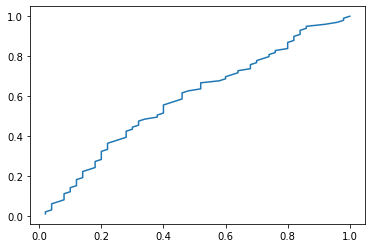

In [65]:
from statsmodels.distributions.empirical_distribution import ECDF
from hyppo.sims import *
from hyppo.ksample._utils import k_sample_transform
pvalues = []
for i in range(1, 100): 
    matrix1, matrix2 = hyppo.sims.trans_2samp(multimodal_independence, 100, 1, noise=True, degree=90, trans=0.3)
    x, y = k_sample_transform([matrix1, matrix2])
    pval = perm_test(x, y)
    pvalues.append(pval)
np.savetxt('C:/Users/siptest/Desktop/NDD/IndependencePvalsPermTestChangeAll.csv',
               pvalues, delimiter=',')    
ecdf = ECDF(pvalues) 
plt.plot(ecdf.x, ecdf.y)
plt.show()

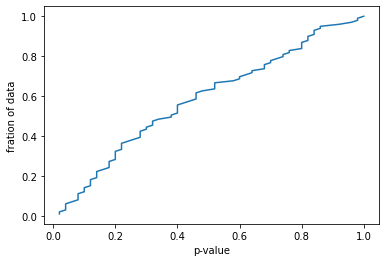

In [70]:
toPlot = np.genfromtxt('C:/Users/siptest/Desktop/NDD/IndependencePvalsPermTestChangeAll.csv', delimiter=',')   
ecdf = ECDF(toPlot)
plt.plot(ecdf.x, ecdf.y)
plt.xlabel("p-value")
plt.ylabel("fration of data")
plt.savefig('C:/Users/siptest/Desktop/NDD/IndependencePvalsPermTest1000reps.pdf')
plt.show()